# Benchmarking a single image
In this notebook, the template matching algorithm is benchmarked

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem.utils.indexation_utils as iutls
import pyxem.utils.polar_transform_utils as ptu

In [2]:
# we load a random image, it doesn't matter
dt = hs.load("data/Cu-Ag_alloy-1000max.blo", lazy=True)
image = dt.inav[0, 0].data.compute()  # for the cpu
image_cp = cp.asarray(image)          # for the gpu
del dt

In [3]:
image.shape

(512, 512)

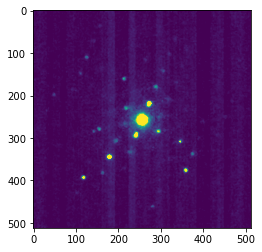

In [4]:
plt.imshow(image, vmax=50)

# Benchmark on CPU
Note: by default Pyxem's CPU implementation uses all available CPU cores on the system to index a pattern. To use only a single core, the source code must be edited.
In the `_match_polar_to_polar_library_cpu` function on line 520 in `pyxem/utils/indexation_utils.py`, the option `parallel` must be set to `False`.

In [7]:
from time import time, sleep
from pyxem.utils import polar_transform_utils as ptutls
n_keep = [1, 500, 1000, 3000, 6000, 10000]
delta_theta = [5, 1, 0.5, 0.2]
spots = [10, 50, 100, 300]

grids = []

max_r = 250
for spot in spots:
    for dt in delta_theta:
        polar_image = ptutls.image_to_polar(image, delta_r=1, delta_theta=dt, max_r=max_r)
        for nk in n_keep:
            # we create some random templates which is easier to deal with
            r = np.random.randint(1, max_r, size=(nk, spot))
            theta = np.random.randint(0, int(360/dt), size=(nk, spot))
            intensities = np.random.rand(nk, spot)
            integrated_templates = iutls._get_integrated_polar_templates(
                polar_image.shape[1],
                r,
                intensities,
                normalize_templates=True,
            )
            print(f"nkeep: {nk}, delta: {dt}")
            times = []
            for i in range(5):
                # things we want to time as it needs to be done each image: the time to convert a pattern to polar coordinates, the time to do a quick index, the time to do a full index
                print(i+1, end=" ")
                start = time()
                ptutls.image_to_polar(image, 1, dt, max_r, False, None)
                #iutls._prefilter_templates(polar_image, r, theta, intensities, integrated_templates, None, nk)
                #iutls._get_full_correlations(polar_image, r, theta, intensities)
                iutls._mixed_matching_lib_to_polar(polar_image, integrated_templates, r, theta, intensities, nk, None, 1)
                end = time()
                times.append(end - start)
            grids.append((nk, dt, spot, np.mean(times), np.std(times)))
            print(r.shape)
grids = np.array(grids)

nkeep: 1, delta: 5
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 5
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 5
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 5
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 5
1 2 3 4 5 (6000, 10)
nkeep: 10000, delta: 5
1 2 3 4 5 (10000, 10)
nkeep: 1, delta: 1
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 1
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 1
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 1
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 1
1 2 3 4 5 (6000, 10)
nkeep: 10000, delta: 1
1 2 3 4 5 (10000, 10)
nkeep: 1, delta: 0.5
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 0.5
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 0.5
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 0.5
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 0.5
1 2 3 4 5 (6000, 10)
nkeep: 10000, delta: 0.5
1 2 3 4 5 (10000, 10)
nkeep: 1, delta: 0.2
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 0.2
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 0.2
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 0.2
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 0.2
1 2 3 4 5 (6000, 10)
nkeep: 10000, d

In [ ]:
import pandas as pd
grid_df = pd.DataFrame(grids, columns=["nk", "dt", "spot", "mean", "std"])
# grid_df.to_csv("pyxem_cpu_time_1_core.csv")  # if the previous cell was run on a single core
grid_df.to_csv("pyxem_cpu_time.csv")

# GPU benchmarking

In [9]:
from time import time, sleep
import cupy as cp
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils.cuda_utils import TPB

n_keep = [1, 500, 1000, 3000, 6000, 10000]
delta_theta = [5, 1, 0.5, 0.2]
spots = [10, 50, 100, 300]

grids_gpu = []

max_r = 250
for spot in spots:
    for dt in delta_theta:
        polar_image = ptutls.image_to_polar(cp.asarray(image), delta_r=1, delta_theta=dt, max_r=max_r)
        for nk in n_keep:
            r = cp.random.randint(1, max_r, size=(nk, spot))
            theta = cp.random.randint(0, int(360/dt), size=(nk, spot))
            intensities = cp.random.rand(nk, spot)
            integrated_templates = iutls._get_integrated_polar_templates(
                polar_image.shape[1],
                r,
                intensities,
                normalize_templates=True,
            )
            print(f"nkeep: {nk}, delta: {dt}")
            times = []
            for i in range(5):
                # things we want to time as it needs to be done each image: the time to convert a pattern to polar coordinates, the time to do a quick index, the time to do a full index
                print(i+1, end=" ")
                start = time()
                image_cp = cp.asarray(image)          # for the gpu
                polar_image = ptutls.image_to_polar(image_cp, 1, dt, 250, False, None)
                answer = iutls._mixed_matching_lib_to_polar(polar_image, integrated_templates, r, theta, intensities, nk, None, 1)
                cp.asnumpy(answer)
                # answer = iutls._get_full_correlations(polar_image, r, theta, intensities)
                end = time()
                times.append(end - start)
            grids_gpu.append((nk, dt, spot, np.mean(times), np.std(times)))
            print(r.shape)
grids_gpu = np.array(grids_gpu)

nkeep: 1, delta: 5
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 5
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 5
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 5
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 5
1 2 3 4 5 (6000, 10)
nkeep: 10000, delta: 5
1 2 3 4 5 (10000, 10)
nkeep: 1, delta: 1
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 1
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 1
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 1
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 1
1 2 3 4 5 (6000, 10)
nkeep: 10000, delta: 1
1 2 3 4 5 (10000, 10)
nkeep: 1, delta: 0.5
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 0.5
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 0.5
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 0.5
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 0.5
1 2 3 4 5 (6000, 10)
nkeep: 10000, delta: 0.5
1 2 3 4 5 (10000, 10)
nkeep: 1, delta: 0.2
1 2 3 4 5 (1, 10)
nkeep: 500, delta: 0.2
1 2 3 4 5 (500, 10)
nkeep: 1000, delta: 0.2
1 2 3 4 5 (1000, 10)
nkeep: 3000, delta: 0.2
1 2 3 4 5 (3000, 10)
nkeep: 6000, delta: 0.2
1 2 3 4 5 (6000, 10)
nkeep: 10000, d

In [ ]:
import pandas as pd
grid_df_gpu = pd.DataFrame(grids_gpu, columns=["nk", "dt", "spot", "mean", "std"])
grid_df_gpu.to_csv("pyxem_gpu_time.csv")

# Analysis of the results

We also compare to benchmark timings of py4DSTEM. Unfortunately these benchmarks can not be run in the same environment as py4DSTEM pins all its package versions. The script to obtain these timings is as follows:

```python
import py4DSTEM
import numpy as np

# Define gold structure using manual definition
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

crystal.calculate_structure_factors(1.5)

q = np.linspace(0,crystal.k_max,100)

atom_sf = py4DSTEM.process.utils.single_atom_scatter(
    [crystal.numbers[0]],
    [1],
    q,
    'A')
atom_sf.get_scattering_factor(
    [crystal.numbers[0]],
    [1],
    q,
    'A');

import time

zone_steps = [3, 1, 0.5]
in_plane_step = [5.0, 1.0, 0.2]

times = []
for z in zone_steps:
    for ips in in_plane_step:
        print("Zone_steps", z, "in_plane_diff", ips)
        # Create an orientation plan
        crystal.orientation_plan(
            angle_step_zone_axis = z,
            angle_step_in_plane = ips,
            accel_voltage = 300e3,
            corr_kernel_size=0.08,
        )
        # measure the average number of spots
        spots = []
        for zv in crystal.orientation_vecs:
            bp = crystal.generate_diffraction_pattern(zone_axis = zv)
            spots.append(bp.data.shape[0])
            
        totalspots = int(round(sum(spots)/len(spots)))
        # Testing some matches
        zone_axis_test = np.array([1,3,5])

        bragg_peaks = crystal.generate_diffraction_pattern(
            zone_axis = zone_axis_test,
            sigma_excitation_error=0.02)
        
        localtimes = []
        for _ in range(5):
            start = time.time()
            orient = crystal.match_single_pattern(
                bragg_peaks,
            )
            stop = time.time()
            localtimes.append(stop-start)
        meantime = np.mean(localtimes)
        stdtime = np.std(localtimes)
        times.append([z, totalspots, ips, meantime, stdtime])
        
import pandas as pd

datatimes = pd.DataFrame(times, columns=["deltaz", "s", "deltaphi", "mean", "std"])
datatimes["N"] = [190, 190, 190, 1596, 1596, 1596, 6105, 6105, 6105]

datatimes.to_csv("timings_py4dstem.csv")
```

It is based on the example in the `ACOM_01_basics` notebook which can be found [here](https://github.com/py4dstem/py4DSTEM_tutorials/tree/9fcc789/notebooks/acom) and times only the `match_single_pattern` function. To run the script, py4DSTEM must be installed as explained in the respository README.

We also compare to one timing result from `Problematic` ([link](https://github.com/stefsmeets/problematic)). Specifically, we time the `indexer.find_orientation` method as used in the example provided [here](https://github.com/stefsmeets/problematic/blob/88cfe04ccdedb62d2bf5654d7fa3003048c8e76c/tutorial/erice_crystallography_school_2018.ipynb).

In [15]:
import pandas as pd
grid_py4dstem = pd.read_csv("data/timings_py4dstem.csv")
grid_py4dstem

,Unnamed: 0,deltaz,s,deltaphi,mean,std,N
0,0,3.0,16,5.0,0.004886,0.000275,190
1,1,3.0,16,1.0,0.022557,0.000092,190
2,2,3.0,16,0.2,0.111324,0.000421,190
3,3,1.0,16,5.0,0.046873,0.000229,1596
4,4,1.0,16,1.0,0.186239,0.001506,1596
5,5,1.0,16,0.2,0.932287,0.009128,1596
6,6,0.5,16,5.0,0.178323,0.000855,6105
7,7,0.5,16,1.0,0.718836,0.002470,6105
8,8,0.5,16,0.2,4.888544,2.645357,6105


In [16]:
from scipy.optimize import curve_fit

In [17]:
import pandas as pd
grid_df = pd.read_csv("pyxem_cpu_time.csv")
grid_df_1core = pd.read_csv("pyxem_cpu_time_1_core.csv")
grid_df_gpu = pd.read_csv("pyxem_gpu_time.csv")

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


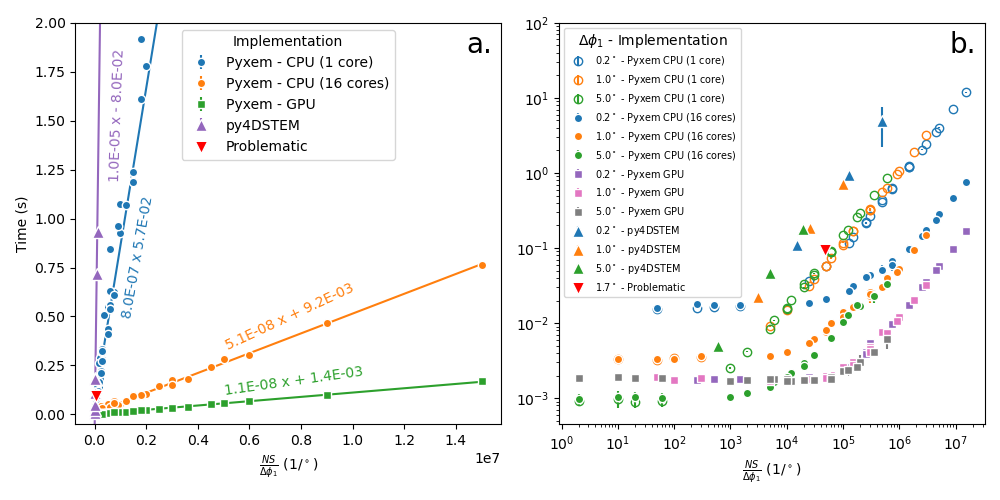

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

line = lambda x, a, b: a*x + b

c = "C0"
x = grid_df_1core["nk"] * grid_df_1core["spot"] / grid_df_1core["dt"]
y = grid_df_1core["mean"]
a, b = curve_fit(line, x, y)[0]
ax[0].errorbar(x, y, yerr=grid_df_1core["std"], label=f"Pyxem - CPU (1 core)", marker="o", ls="None", markeredgecolor="white", color=c)
xx = np.linspace(0, 1.5e7)
ax[0].plot(xx, line(xx, a, b), color=c)
ax[0].text(0.1e7, 0.5, f"{a:.1E} x {b:.1E}", rotation=80, color=c)

c = "C1"
x = grid_df["nk"] * grid_df["spot"] / grid_df["dt"]
y = grid_df["mean"]
a, b = curve_fit(line, x, y)[0]
ax[0].errorbar(x, y, yerr=grid_df["std"], label=f"Pyxem - CPU (16 cores)", marker="o", ls="None", markeredgecolor="white", color=c)
xx = np.linspace(0, 1.5e7)
ax[0].plot(xx, line(xx, a, b), color=c)
ax[0].text(0.5e7, 0.33, f"{a:.1E} x + {b:.1E}", rotation=25, color=c)

c = "C2"
x = grid_df_gpu["nk"] * grid_df_gpu["spot"] / grid_df_gpu["dt"]
y = grid_df_gpu["mean"]
a, b = curve_fit(line, x, y)[0]
ax[0].errorbar(x, y, yerr=grid_df_gpu["std"], label=f"Pyxem - GPU", marker="s", ls="None", markeredgecolor="white", color=c)
xx = np.linspace(0, 1.5e7)
ax[0].plot(xx, line(xx, a, b), color=c)
ax[0].text(0.5e7, 0.1, f"{a:.1E} x + {b:.1E}", rotation=8, color=c)

# py4dstem
c = "C4"
x = grid_py4dstem["N"] * grid_py4dstem["s"] / grid_py4dstem["deltaphi"]
y = grid_py4dstem["mean"]
a, b = curve_fit(line, x, y)[0]
ax[0].errorbar(x, y, yerr=grid_py4dstem["std"], label=f"py4DSTEM", marker="^", ls="None", markersize=8, markeredgecolor="white", color=c)
xx = np.linspace(0, 1.5e7)
ax[0].plot(xx, line(xx, a, b), color=c)
ax[0].text(0.05e7, 1.2, f"{a:.1E} x - {-b:.1E}", rotation=88, color=c)

# add problematic
x = [746*107/1.7] # N * Spots / delta phi
y = [0.093]
ax[0].scatter(x, y, color="red",  marker="v", label="Problematic", zorder=10, edgecolor="white", s=80)
ax[1].scatter(x, y, color="red",  marker="v", label="1.7$^\circ$ - Problematic", zorder=10, edgecolor="white", s=80)

groups = grid_df_1core.groupby("dt")
colors = ["C0", "None", "C1", "C2"]
for col, (name, group) in zip(colors, groups):
    #print(group)
    if np.all(0.5 == group["dt"]):
        continue
    x = group["nk"] * group["spot"] / group["dt"]
    ax[1].errorbar(x, group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$ - Pyxem CPU (1 core)",
                marker="o", ls="None", markeredgecolor=col, ecolor=col, color="None",
               )
    
groups = grid_df.groupby("dt")
for name, group in groups:
    #print(group)
    if np.all(0.5 == group["dt"]):
        continue
    x = group["nk"] * group["spot"] / group["dt"]
    ax[1].errorbar(x, group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$ - Pyxem CPU (16 cores)",
                marker="o", ls="None", markeredgecolor="white",
               )

groups = grid_df_gpu.groupby("dt")
for i, (name, group) in enumerate(groups):
    #print(group)
    if np.all(0.5 == group["dt"]):
        continue
    x = group["nk"] * group["spot"] / group["dt"]
    ax[1].errorbar(x, group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$ - Pyxem GPU",
                marker="s", ls="None", color=f"C{i+4}", markeredgecolor="white",
               )
    
groups = grid_py4dstem.groupby("deltaphi")
colors = ["C0", "C1", "C2"]
for color, (name, group) in zip(colors, groups):
    x = group["N"] * group["s"] / group["deltaphi"]
    ax[1].errorbar(x, group["mean"], yerr=group["std"], label=f"{name}"+r"$^\circ$ - py4DSTEM",
                marker="^", ls="None", color=color, markeredgecolor="white", markersize=8,
               )
    
ax[0].set_ylabel(r"Time (s)")
ax[0].legend(title=r"Implementation")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend(title=r"$\Delta \phi_1$ - Implementation", fontsize=8)
for i in ax:
    i.set_xlabel(r"$\frac{NS}{\Delta \phi_1}$ (1/$^\circ$)")
    
#ax[0].set_ylim(-0.05, 1)
ax[0].set_ylim(-0.05, 2)
ax[1].set_ylim(None, 1e2)

frac=0.98
xx1, xx2 = ax[0].get_xlim()
yy1, yy2 = ax[0].get_ylim()
xx = frac*(xx2 - xx1) + xx1
yy = frac*(yy2 - yy1) + yy1
ax[0].text(xx, yy, "a.", va="top", ha="right", fontsize=20)
xx1, xx2 = ax[1].get_xlim()
yy1, yy2 = ax[1].get_ylim()
xx = xx1*10**(frac*(np.log10(xx2) - np.log10(xx1)))
yy = yy1*10**(frac*(np.log10(yy2) - np.log10(yy1)))
#yy = frac*(yy2 - yy1) + yy1
ax[1].text(xx, yy, "b.", va="top", ha="right", fontsize=20)

# reorder legend entries
handles,labels = ax[0].get_legend_handles_labels()
order = [1, 2, 3, 4, 0]
handles = [handles[o] for o in order]
labels = [labels[o] for o in order]
ax[0].legend(handles,labels, title="Implementation", loc=9)

handles,labels = ax[1].get_legend_handles_labels()
handles = [*handles[1:], handles[0]]
labels = [*labels[1:], labels[0]]
ax[1].legend(handles,labels, title=r"$\Delta \phi_1$ - Implementation", fontsize=7)

fig.tight_layout()

In [ ]:
fig.savefig("210903DataImages/benchmarking_2.png", dpi=320)